Stock price prediction program, licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

# General libraries

In [33]:
# Importing the numpy library (for arrays operations)
# Importing the pandas library (for data analysis)
# Importing the matplotlib.pyplot interface (for MATLAB-like plots)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset preparation
We start by loading the dataset (csv file) we shall work with. We use Netflix stock price from 04/04/2013 to 04/04/2022 retrieved from <b>investing.com</b>:<br>
https://www.investing.com/equities/netflix,-inc.-historical-data

In [34]:
# Storing the data in DataFrame "df", sorted by date in ascending order

df = pd.read_csv('NFLX Historical Data.csv')
df = df[::-1]
df

,Date,Price,Open,High,Low,Vol.,Change %
2268,"Apr 04, 2013",23.81,23.91,24.30,23.40,34.46M,-1.81%
2267,"Apr 05, 2013",23.52,23.36,24.36,23.22,32.52M,-1.22%
2266,"Apr 08, 2013",23.29,23.69,23.76,22.71,31.76M,-0.98%
2265,"Apr 09, 2013",24.19,23.36,24.48,23.15,34.08M,3.86%
2264,"Apr 10, 2013",23.72,24.00,24.21,23.56,29.73M,-1.94%
...,...,...,...,...,...,...,...
4,"Mar 29, 2022",391.82,384.39,396.50,380.33,5.81M,3.52%
3,"Mar 30, 2022",381.47,389.55,392.70,378.63,4.00M,-2.64%
2,"Mar 31, 2022",374.59,383.59,384.00,373.61,4.12M,-1.80%
1,"Apr 01, 2022",373.47,376.80,380.87,368.50,4.64M,-0.30%


In [35]:
# Storing "Price" values of "df" in a numpy array "arr", and reshaping it into a vertical array

arr = df['Price'].values
arr = arr.reshape(-1, 1)
arr.shape

(2269, 1)

We split the data into a training set stored in an array "arr_train" (first 80% of the rows of "arr") and a test set stored in an array "arr_test" (last 20% of the rows of "arr"). We also store in a list "dates" the dates corresponding to "arr_test"

In [36]:
arr_train = arr[:int(arr.shape[0]*0.8)]
arr_test = arr[int(arr.shape[0]*0.8):]
dates = df['Date'].tolist()[int(arr.shape[0]*0.8):]

print('Shape of arr_train:', arr_train.shape)
print('Shape of arr_train:', arr_test.shape)
print('Length of dates:', len(dates))

Shape of arr_train: (1815, 1)
Shape of arr_train: (454, 1)
Length of dates: 454


We import the estimator "MinMaxScaler" from the sklearn.preprocessing module to rescale the data to a given range, in our case the interval [0,1].<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Rescaling "arr_train" and "arr_test" to the interval [0,1]

scaler = MinMaxScaler()
arr_train = scaler.fit_transform(arr_train)
arr_test = scaler.fit_transform(arr_test)

print('Rescaled arr_train:\n', arr_train)

Rescaled arr_train:
 [[1.20677651e-03]
 [5.33766535e-04]
 [0.00000000e+00]
 ...
 [9.16175447e-01]
 [9.33418427e-01]
 [9.58087723e-01]]


We define a function "arrays" which creates two numpy arrays x, y from an input array "arr" and an input number of time steps "n". The 1D numpy array y contains all the last values of arr, starting from the n-th value. The 2D numpy array x contains all the lists of n consecutive values of arr.

In [38]:
def arrays(arr, n):
    x, y = [], []
    for i in range(n, arr.shape[0]):
        x.append(arr[i-n: i, 0])
        y.append(arr[i, 0])
    x, y = np.array(x), np.array(y)
    return x,y 

In [39]:
# Using the function "create_data" with a given value of n to create the training and test datasets for the RNN model
# Storing in "dates" the list of dates corresponding to "y_test"

n = 50
x_train, y_train = arrays(arr_train, n)
x_test, y_test = arrays(arr_test, n)
dates = dates[n:]

print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)
print('Number of dates:', len(dates))

Shape of x_train: (1765, 50)
Shape of y_train: (1765,)
Shape of x_test: (404, 50)
Shape of y_test: (404,)
Number of dates: 404


In [40]:
# Reshaping "x_train" and "x_test" into the 3D format needed for the LSTM input layer of the RNN model
# The 3D format includes number of rows, size of the sample and number of features (here 1 for "Price" values)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print('New shape of x_train:', x_train.shape)
print('New shape of x_test:', x_test.shape)

New shape of x_train: (1765, 50, 1)
New shape of x_test: (404, 50, 1)


# RNN model

In [41]:
# Importing the "Sequential" class from the keras.models API (to group a linear stack of layers into a model)
# Importing the "load_model" function from the keras.models API (to load a model saved via model.save())
# Importing the "LSTM" class from the keras.layers API (to load the long short-term memory layer to be used)
# Importing the "Dense" class from the keras.layers API (to load the regular densely-connected NN layer to be used)
# Importing the "Dropout" class from the keras.layers API (to apply dropout to the input)

# See https://keras.io/api/models/sequential/
# See https://keras.io/api/models/model_saving_apis/#loadmodel-function
# See https://keras.io/api/layers/recurrent_layers/lstm/
# See https://keras.io/api/layers/regularization_layers/dropout/
# See https://keras.io/api/layers/core_layers/dense/

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

We define a RNN model which takes as input the stock prices of n consecutive days and gives as output a prediction of stock price at day n+1.

- We set the class of the model as <b>Sequential</b>.
- We add three <b>LSTM</b> layers with a given number of <b>units</b> (dimension of the output space), <b>return_sequences=True</b> (???) and <b>input_shape=(n, 1)</b> (n time steps and 1 feature).
- We add between each layer a <b>Dropout</b> layer which randomly sets input units to 0 with frequency rate r.

In [42]:
# Adding a last dense layer providing the prediction of the next day stock price

r = 0.1
model = Sequential()

model.add(LSTM(units=96, return_sequences=True, input_shape=(n, 1)))
model.add(Dropout(r))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(r))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(r))
model.add(LSTM(units=96))
model.add(Dropout(r))
model.add(Dense(units=1))

In [43]:
# Summary of the RNN model

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 96)            37632     
                                                                 
 dropout_4 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_5 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_6 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_7 (LSTM)               (None, 96)               

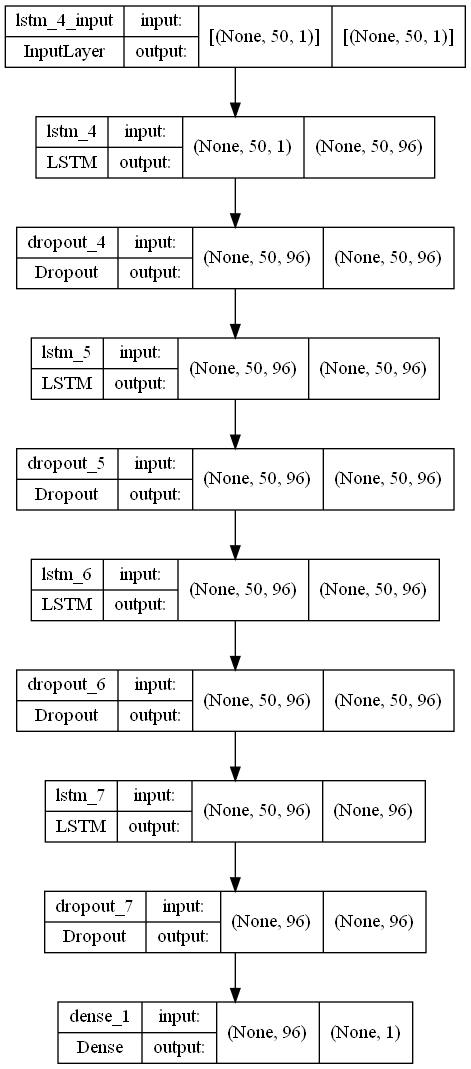

In [49]:
# Importing the "plot_model" function from keras.utils.vis_utils module (to plot a graph of the model)
# See https://keras.io/api/utils/model_plotting_utils/#plot_model-function

from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We compile the model using the mean square error (mse) between labels and predictions as quantity to minimise during the training process. And we use "adam" as optimizer (a variant of the stochastic gradient descent algorithm).<br>
https://keras.io/api/optimizers/adam/

In [45]:
model.compile(loss='mse', optimizer='adam')

In [46]:
# Training the model with a given number of epochs and batch size
# Saving the model's attributes in a HDF5 file
# See https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format

model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_price.h5')

Epoch 1/50
56/56 [==============================] - 8s 66ms/step - loss: 0.0142
Epoch 2/50
56/56 [==============================] - 5s 92ms/step - loss: 0.0026
Epoch 3/50
56/56 [==============================] - 6s 101ms/step - loss: 0.0030
Epoch 4/50
56/56 [==============================] - 6s 101ms/step - loss: 0.0023
Epoch 5/50
56/56 [==============================] - 6s 101ms/step - loss: 0.0023
Epoch 6/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0023
Epoch 7/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0016
Epoch 8/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0018
Epoch 9/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0016
Epoch 10/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0016
Epoch 11/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0016
Epoch 12/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0021
Epoch 13/50
56/56 [==========

In [47]:
# Storing in numpy array "predicted_prices" the stock prices predicted by the model
# Storing in numpy array "real_prices" the real stock prices contained in "y_test"
# Rescaling the values of both arrays to the original scale

model = load_model('stock_price.h5')

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisation of results

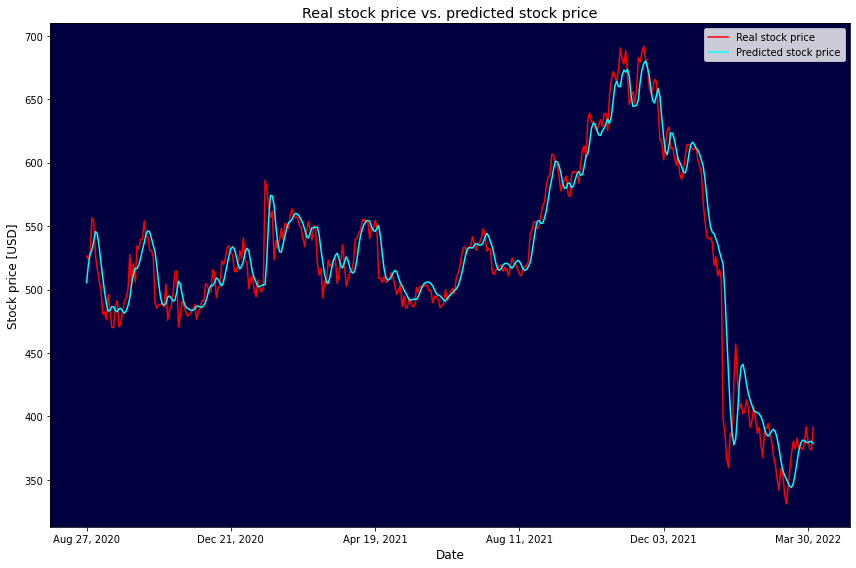

In [48]:
# Line plot of real stock prices vs. predicted stock prices

_, p = plt.subplots(figsize=(12,8))

p.plot(dates, real_prices, color='r', label='Real stock price')
p.plot(dates, predicted_prices, color='cyan', label='Predicted stock price')

# Parameters, title and legend of the line plot

p.set_title('Real stock price vs. predicted stock price', size='x-large')
p.set_ylabel('Stock price [USD]', size='large')
plt.xticks(np.arange(0, len(dates)+1, 80))
p.set_xlabel('Date', size='large')
p.set_facecolor('#000040')
p.legend()

plt.tight_layout()